In [139]:
import sys
sys.path

['',
 '/home/djeffrie/Dropbox/My_Dropbox_Scripts/Python/RAD-seq/MISC',
 '/home/djeffrie/anaconda/lib/python27.zip',
 '/home/djeffrie/anaconda/lib/python2.7',
 '/home/djeffrie/anaconda/lib/python2.7/plat-linux2',
 '/home/djeffrie/anaconda/lib/python2.7/lib-tk',
 '/home/djeffrie/anaconda/lib/python2.7/lib-old',
 '/home/djeffrie/anaconda/lib/python2.7/lib-dynload',
 '/home/djeffrie/anaconda/lib/python2.7/site-packages',
 '/home/djeffrie/anaconda/lib/python2.7/site-packages/Sphinx-1.3.1-py2.7.egg',
 '/home/djeffrie/anaconda/lib/python2.7/site-packages/cryptography-0.9.1-py2.7-linux-x86_64.egg',
 '/home/djeffrie/anaconda/lib/python2.7/site-packages/setuptools-17.1.1-py2.7.egg',
 '/home/djeffrie/anaconda/lib/python2.7/site-packages/IPython/extensions',
 '/usr/local/lib/python2.7/dist-packages',
 '/usr/local/lib/python2.7/dist-packages/PyVCF-0.6.8.dev0-py2.7.egg',
 '/home/djeffrie/Dropbox/My_Dropbox_Scripts/Misc',
 '/home/djeffrie/Dropbox/My_Dropbox_Scripts/Genemodels',
 '/home/djeffrie/Dropb

In [1]:
import csv
import os
import vcf
import operator
import numpy as np
from matplotlib import pyplot as plt
from __future__ import division
from collections import Counter
import Incremental_Pop_mod as Inc_Pop
import MISC_RAD_tools

%matplotlib inline

### So . . . . having no luck with the first batch of sequencing, we added a second lane. The analyses below start from a comparison of the coverage between just one lane and having two lanes of data. 
See below the functions for the start of the analyses

In [2]:
def parth_loc_finder(record, parthenogens, sexuals, parth_threshold, sexuals_threshold):
    
    N_Homozygous_parths = 0
    n_parths_called = 0
    n_sexuals_called = 0
    Parth_hom_allele = []
    Het_or_alt_hom_sexuals = 0
    N_sexuals_not_hom_for_parth_allele = 0

    ## Is the locus homozygous in all parthenogens? ----------------------------------------------
    
    for sample in record.samples:
        sample_name = sample.sample
        
        if sample_name in parthenogens:
            
            #print sample_name, "called? =", sample.called, "Het? = ", sample.is_het, sample.gt_bases
            if sample.called == True:
                n_parths_called += 1
                #print "%s: %s" % (sample_name, sample.gt_bases)
                if sample.is_het == False:
                    N_Homozygous_parths += 1
                    Parth_hom_allele.append(sample.gt_bases.split("/")[0])
    
                    
    
    Parth_hom_thresh_limit_exceeded = False ## default state
    
    if N_Homozygous_parths >= n_parths_called*parth_threshold:
        Homozygous_in_parthenogens = True ## If there are enough homozygous parthenogens. . . 

        ## Are all parthenogens homozygous for the same allele?
        
        if len(set(Parth_hom_allele))  == 1: ## if parthenogens are all homozygous for the same allele then it is OK
            Parthenogens_hom_for_same_allele = True
            Parthogen_allele = list(set(Parth_hom_allele))[0]

        elif len(set(Parth_hom_allele))  > 1: ## or if enough (over set threshold) parthenogens are homozygous for the same allele then it is still OK

            major_parth_allele = max(Counter(Parth_hom_allele).values())
            minor_parth_allele = min(Counter(Parth_hom_allele).values())

            if major_parth_allele/n_parths_called >= parth_threshold: 
                Parth_hom_thresh_limit_exceeded = True
                Parthenogens_hom_for_same_allele = True
                Parthogen_allele = max(Counter(Parth_hom_allele).iteritems(), key=operator.itemgetter(1))[0]
                

            else:
                Parthenogens_hom_for_same_allele = False
                
        else:
            Parthenogens_hom_for_same_allele = False
            
    else:
        Homozygous_in_parthenogens = False
        Parthenogens_hom_for_same_allele = False
        
    
    
    ## If the locus is homozygous in parthenogens, is it heterozygous or homozygous for the other allele in sexuals?

    if Homozygous_in_parthenogens == True and Parthenogens_hom_for_same_allele == True:
        #print "Yes looking in sexuals"
        for sample in record.samples:
            sample_name = sample.sample
            if sample_name in sexuals:
                if sample.called == True:
                    n_sexuals_called += 1
                    #print "%s : %s" % (sample_name, sample.gt_bases)
                    
                    if sample.is_het == True: ## if sexuals are heterozygous then the locus in this sample is still ok so count it.
                        N_sexuals_not_hom_for_parth_allele += 1
                        
                    elif sample.is_het == False: ## if sample is homozygous, then check that it is homozygous for the other allele
                        
                        if sample.gt_bases.split("/")[0] != Parthogen_allele: ## If so, locus for this sample is ok, so count it
                            N_sexuals_not_hom_for_parth_allele += 1
                            

        if N_sexuals_not_hom_for_parth_allele >= n_sexuals_called*sexuals_threshold:
            Het_or_alt_hom_in_sexuals = True
            
        else:
            Het_or_alt_hom_in_sexuals = False
            
            
        if Homozygous_in_parthenogens == True:
            if Parthenogens_hom_for_same_allele == True or Parth_hom_thresh_limit_exceeded == True:
                if Het_or_alt_hom_in_sexuals == True:
                    print "\nLocus %s_%s" % (record.ID, record.POS)
                    print "Threshold number of Parthenogens = %s and Sexuals = %s" % (n_parths_called*parth_threshold, n_sexuals_called*sexuals_threshold)
                    print "The number of homozygous Parthenogens = %s out of %s called" % (N_Homozygous_parths, n_parths_called)
                    print "The number of Sexuals not homozygous for same allele = %s out of %s called" % (N_sexuals_not_hom_for_parth_allele, n_sexuals_called)
                    print "So enough Parthenogens are over the homozygosity threshold for one allele"
                    print "And enough sexuals are heterozygous or homozygous for alternative allele"

In [142]:
### Looking only for alleles that are present in sexuals, and not in parthenogens

def Sexuals_specific_locus_finder(vcf_object,sexuals, parthenogens, parths_threshold = 0.95, sexuals_threshold = 0.05):
    
    ## parths_threshold - the sexual allele has to be absent from at least this many parthenogens. Default 95%
    ## sexuals_threshold - an allele has to be present in at least this number of sexuals to be counted. Default 5%
    
    sex_spec_allele_loci = []
    
    print sexuals
    
    
    for record in vcf_object:
        
        N_Homozygous_parths = 0
        N_parths_called = 0
        N_parths_without_sex_allele = 0
        N_sexuals_called = 0
        Parth_hom_allele = []
        Het_or_alt_hom_sexuals = 0
        Sex_removed = None
        Parth_removed = None

        ## Get the alleles in the sexual? ----------------------------------------------

        Sexuals_alleles = []
        Parthenogen_alleles = []
        #print "Sexuals"

        for sample in record.samples:
            sample_name = sample.sample
            
            
            if sample_name in sexuals:                

                if sample.called == True:
                    N_sexuals_called += 1
                    [Sexuals_alleles.append(i) for i in sample.gt_bases.split("/")] ## both alleles added!
        
          
        
        major_sex_allele = max(Counter(Sexuals_alleles).values())
        minor_sex_allele = min(Counter(Sexuals_alleles).values())
        Major_sex_allele = max(Counter(Sexuals_alleles).iteritems(), key=operator.itemgetter(1))[0]         
        Minor_sex_allele = min(Counter(Sexuals_alleles).iteritems(), key=operator.itemgetter(1))[0]
        
        if minor_sex_allele < N_sexuals_called*sexuals_threshold:
            Sexuals_alleles = [x for x in Sexuals_alleles if x != Minor_sex_allele] # removes minor allele from the list.
            Sex_removed = Minor_sex_allele
        

        for sample in record.samples:
            sample_name = sample.sample
            
            if sample_name in parthenogens:
                
                if sample.called == True:
                    N_parths_called += 1
                    [Parthenogen_alleles.append(i) for i in sample.gt_bases.split("/")]
                    
        major_parth_allele = max(Counter(Parthenogen_alleles).values())
        minor_parth_allele = min(Counter(Parthenogen_alleles).values())
        Major_parth_allele = max(Counter(Parthenogen_alleles).iteritems(), key=operator.itemgetter(1))[0]
        Minor_parth_allele = min(Counter(Parthenogen_alleles).iteritems(), key=operator.itemgetter(1))[0]
        
        if minor_parth_allele < N_parths_called*parths_threshold:
            Parthenogen_alleles = [x for x in Parthenogen_alleles if x != Minor_parth_allele] # removes minor allele from the list.
            Parth_removed = Minor_parth_allele
        shared = True
        
        for allele in set(Sexuals_alleles):
            if not allele in set(Parthenogen_alleles):
                shared = False
                sexual_allele = allele
        if shared == False:
            print "record %s_%s" % (record.ID, record.POS)
            print "Parthenogen alleles = %s" % set(Parthenogen_alleles)
            if Parth_removed != None:
                print "Allele %s was removed from pathenogens as its freq was below the threshold (%s)" % (Minor_parth_allele, parths_threshold)
                
            print "Sexual alleles = %s" % set(Sexuals_alleles)
            if Sex_removed != None:
                print "Allele %s was removed from sexuals as its freq was below the threshold (%s)" % (Minor_sex_allele, parths_threshold)
                
            print "Sexual specific allele: %s" % (sexual_allele)
            sex_spec_allele_loci.append("%s_%s" % (record.ID, record.POS))
                
    return sex_spec_allele_loci



In [143]:
## Function to get allele freqs from the stacks sumstats output file

def Freq_plotter(sumstats):
    
    ## sumstats is a file handle
    
    sumstats = sumstats.readlines()
    
    sex_freqs = []
    parth_freqs = []

    for line in sumstats:
        if not line.startswith("#"):
            group = line.split()[5]
            Loc = "%s_%s" % (line.split()[1], line.split()[3])
            P = float(line.split()[9])
            Q = 1-P

            if group == "sex" or group == "S" or group == "s":
                sex_freqs.append(P)
            elif group == "parth" or group == "P" or group == "p":
                parth_freqs.append(P)

    fig = plt.figure(figsize=(10,10))

    fig.add_subplot(1,2,1)
    plt.hist(sex_freqs, color = "blue", alpha = 0.4, bins=100)
    plt.xlabel("Major allele frequency", fontsize = 10)
    plt.ylabel("N_loci", fontsize = 10)
    plt.title("Sexuals", fontsize = 13)

    fig.add_subplot(1,2,2)
    plt.hist(parth_freqs, color = "blue", alpha = 0.4, bins = 100)
    plt.xlabel("Major allele frequency", fontsize = 10)
    plt.ylabel("N_loci", fontsize = 10)
    plt.title("Parthenogens", fontsize = 13)

    plt.show()       
    
    fig2 = plt.figure(figsize=(10,10))
    
    plt.scatter(sex_freqs,parth_freqs)
    plt.xlabel("Sexuals")
    plt.ylabel("Parthenogens")
    
    plt.show()

        
        

        

In [144]:
## Get sexuals and parthenogens from pop map
def get_sex_info(pop_map_file):
    sexuals = []
    parthenogens = []
    for line in open(pop_map_file, 'r').readlines():
        line = line.strip()
        if line.split()[1] == "sex" or line.split()[1] == "S" or line.split()[1] == "s":
            sexuals.append(line.split()[0])
        elif line.split()[1] == "parth" or line.split()[1] == "P" or line.split()[1] == "p":
            parthenogens.append(line.split()[0])


    N_sexuals = len(sexuals)
    N_partenogens = len(parthenogens)

    print N_sexuals, "Sexuals", sexuals
    print N_partenogens, "Parthenogens", parthenogens
    
    return sexuals, parthenogens


In [145]:
## vcf and popmap paths:

## Lane1 all samples

vcf_L1_all = "/home/djeffrie/Data/Caspers_data/1lane/populations/r_075_allsamples/batch_1b.vcf"
vcf_L1_all_alt = "%s%s" %(vcf_L1_all, ".altered")
vcf_L1_all_popmap = "/home/djeffrie/Data/Caspers_data/2lanes/Stacks_outs/Populations_all/pop_map_all.txt"
# vcf_L1_all_sumstats = dont have this . . . 

## Lane2 all samples

vcf_L2_all ="/home/djeffrie/Data/Caspers_data/2lanes/Stacks_outs/Populations_all/batch_2.vcf"
vcf_L2_all_alt = "%s%s" %(vcf_L2_all, ".altered")
vcf_L2_all_popmap = "/home/djeffrie/Data/Caspers_data/2lanes/Stacks_outs/Populations_all/pop_map_all.txt"
vcf_L2_all_sumstats ="/home/djeffrie/Data/Caspers_data/2lanes/Stacks_outs/Populations_all/batch_2.sumstats.tsv"

## Lane2 best kept samples

vcf_L2_best = "/home/djeffrie/Data/Caspers_data/2lanes/Stacks_outs/Populations_best_kept/batch_2.vcf"
vcf_L2_best_alt = "%s%s" %(vcf_L2_best, ".altered")
vcf_L2_best_popmap = "/home/djeffrie/Data/Caspers_data/2lanes/Stacks_outs/Populations_best_kept/pop_codes_best.txt"
vcf_L2_best_sumstats = "/home/djeffrie/Data/Caspers_data/2lanes/Stacks_outs/Populations_best_kept/batch_2.sumstats.tsv"

## Lane2 clutch 026

vcf_c026 = "/home/djeffrie/Data/Caspers_data/2lanes/Stacks_outs/Populations_clutch_026/batch_2.vcf"
vcf_c026_alt = "%s%s" %(vcf_c026, ".altered")
vcf_c026_popmap = "/home/djeffrie/Data/Caspers_data/2lanes/Stacks_outs/Populations_clutch_026/pop_codes_C026.txt"
vcf_c026_sumstats = "/home/djeffrie/Data/Caspers_data/2lanes/Stacks_outs/Populations_clutch_026/batch_2.sumstats.tsv"

## Lane2 clutch 030

vcf_c030 = "/home/djeffrie/Data/Caspers_data/2lanes/Stacks_outs/Populations_clutch_030/batch_2.vcf"
vcf_c030_alt = "%s%s" %(vcf_c030, ".altered")
vcf_c030_popmap = "/home/djeffrie/Data/Caspers_data/2lanes/Stacks_outs/Populations_clutch_030/pop_codes_C030.txt"
vcf_c030_sumstats = "/home/djeffrie/Data/Caspers_data/2lanes/Stacks_outs/Populations_clutch_030/batch_2.sumstats.tsv"

## Lane2 clutch 091

vcf_c091 = "/home/djeffrie/Data/Caspers_data/2lanes/Stacks_outs/Populations_clutch_091/batch_2.vcf"
vcf_c091_alt = "%s%s" %(vcf_c091, ".altered")
vcf_c091_popmap = "/home/djeffrie/Data/Caspers_data/2lanes/Stacks_outs/Populations_clutch_091/pop_codes_C091.txt"
vcf_c091_sumstats = "/home/djeffrie/Data/Caspers_data/2lanes/Stacks_outs/Populations_clutch_091/batch_2.sumstats.tsv"



In [17]:
## Alter vcf header for PyVCF for all vcfs above.

for vcf_path in [vcf_L1_all, vcf_L2_all, vcf_L2_best, vcf_c026, vcf_c030, vcf_c091]:
    
    myvcf = open(vcf_path, 'r').readlines()
    alteredvcfpath = "%s%s" %(vcf_path, ".altered")
    alteredvcf = open(alteredvcfpath, 'w')
    print "Altered file: %s" % alteredvcfpath    
    
    for line in myvcf:
        if "Allele Depth" not in line:
            alteredvcf.write(line)
        elif "Allele Depth" in line:
            line = '##FORMAT=<ID=AD,Number=.,Type=Integer,Description="Allele Depth">\n'
            alteredvcf.write(line)
    alteredvcf.close()
    


Altered file: /home/djeffrie/Data/Caspers_data/1lane/populations/r_075_allsamples/batch_1b.vcf.altered
Altered file: /home/djeffrie/Data/Caspers_data/2lanes/Stacks_outs/Populations_all/batch_2.vcf.altered
Altered file: /home/djeffrie/Data/Caspers_data/2lanes/Stacks_outs/Populations_best_kept/batch_2.vcf.altered
Altered file: /home/djeffrie/Data/Caspers_data/2lanes/Stacks_outs/Populations_clutch_026/batch_2.vcf.altered
Altered file: /home/djeffrie/Data/Caspers_data/2lanes/Stacks_outs/Populations_clutch_030/batch_2.vcf.altered
Altered file: /home/djeffrie/Data/Caspers_data/2lanes/Stacks_outs/Populations_clutch_091/batch_2.vcf.altered


### All samples, lane 1 only
Note** In the first lane analyses it became clear that there were a lot of loci with very rare alleles. So all analyses here have been done with a --min_maf cutoff of 0.05

In [146]:
## get numbers of sexuals and parthenogens
sexuals, parthenogens = get_sex_info(vcf_L1_all_popmap)

IOError: [Errno 20] Not a directory: '/home/djeffrie/Data/Caspers_data/1lane/out5/Populations_outs_minmaf/batch_1.vcf.altered/home/djeffrie/Data/Caspers_data/2lanes/Stacks_outs/Populations_all/pop_map_all.txt'

#### Now we take a quick look at the data, to see what the frequencies look like for each population (can't do this for Lane 1 - dont have sumstats file)

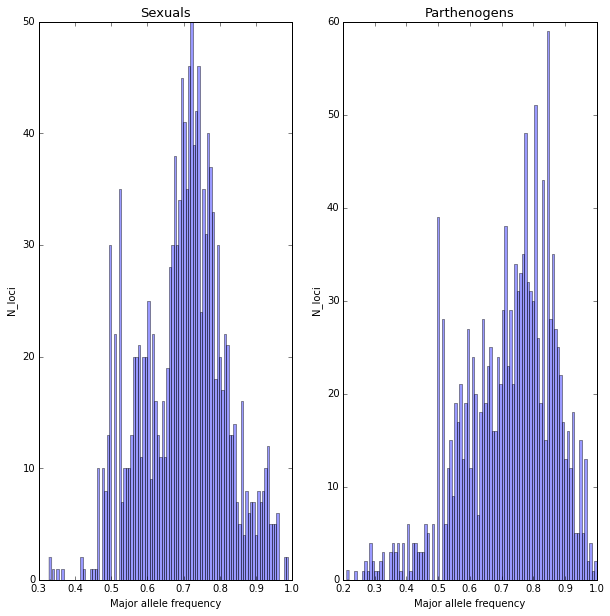

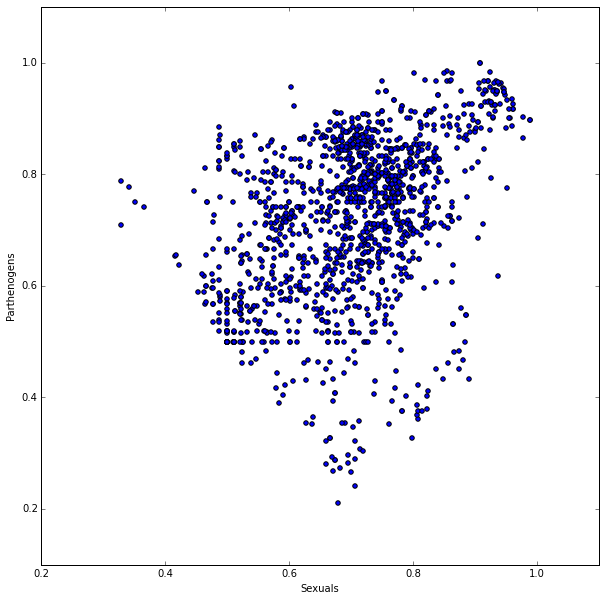

In [42]:
Freq_plotter(open(vcf_L2_all_sumstats, 'r'))

Average coverage per SNP across all samples . . . .

Number of tags =  4573
Average tag coverage 30.576943242 (+- 22.9650339731 )


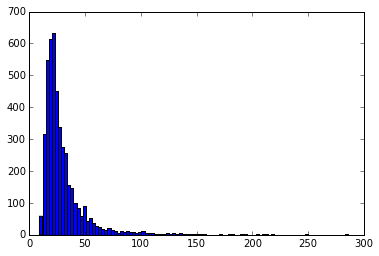

In [31]:
MISC_RAD_tools.av_tag_cov(vcf_L1_all_alt, "/home/djeffrie/Data/Caspers_data/1lane/populations/r_075_allsamples/Av_snp_cov.txt")

Average sample coverage averaged across SNPs

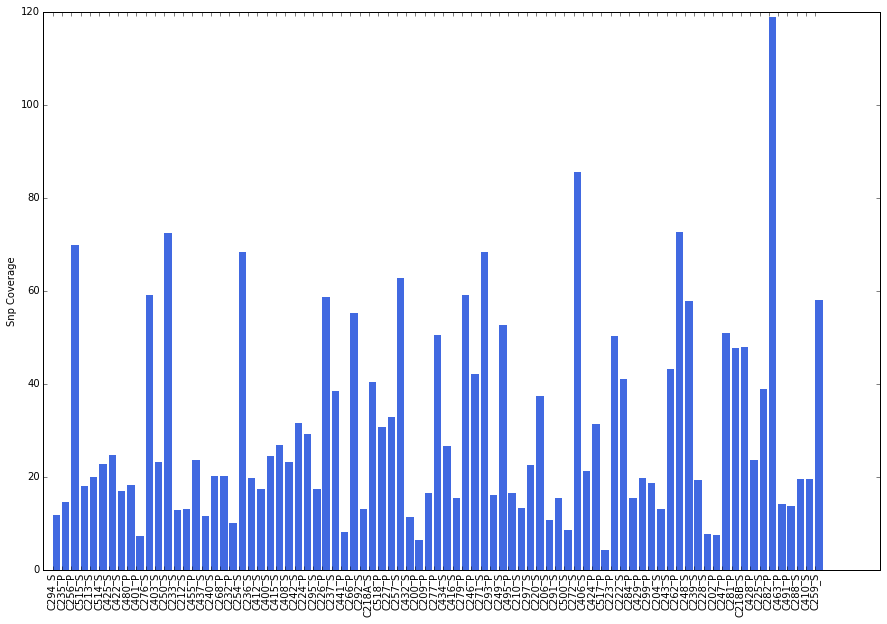

In [32]:
MISC_RAD_tools.sample_Avcov_from_vcf(vcf_L1_all_alt, "/home/djeffrie/Data/Caspers_data/1lane/populations/r_075_allsamples/Av_sample_cov.txt")

In [104]:
## Run the function over the vcf

vcf_read = vcf.Reader(open("/home/djeffrie/Data/Caspers_data/1lane/populations/r_075_allsamples/batch_1b.vcf.altered", 'r'))

## Useing the parth_loc_finder function. This function looks for loci that exactly fit the recessive mendelien inheritance pattern we expect to see.
## Two important thresholds:
# parth_threshold = the proportion of parthenogens that must be homozygous for the same allele
# sexuals_threshold = the proportion of sexuals that must be homozygous for the "non-parthenogen" allele or heterozygous

for vcfrecord in vcf_read:
    parth_loc_finder(vcfrecord, parthenogens, sexuals, 0.6, 0.8) ## parth_loc_finder(record, parth_threshold, sexuals_threshold)



Locus 4873_453127
Threshold number of Parthenogens = 15.6 and Sexuals = 30.4
The number of homozygous Parthenogens = 18 out of 26 called
The number of Sexuals not homozygous for same allele = 33 out of 38 called
So enough Parthenogens are over the homozygosity threshold for one allele
And enough sexuals are Heterozygous or homozygous for alternative allele


So we find nothing. The thresholds for the number of homozygous asexuals and sexuals not homozygous for the same allele have to be very low for us to be able to find any loci that fit the expectation.

### All samples Lanes 1 + 2

In [106]:
## get numbers of sexuals and parthenogens
sexuals, parthenogens = get_sex_info(vcf_L2_all_popmap)

49 Sexuals ['C204_S', 'C206_S', 'C210_S', 'C212_S', 'C213_S', 'C218A_S', 'C218B_S', 'C220_S', 'C222_S', 'C225_S', 'C228_S', 'C233_S', 'C236_S', 'C237_S', 'C239_S', 'C240_S', 'C242_S', 'C243_S', 'C248_S', 'C249_S', 'C250_S', 'C254_S', 'C257_S', 'C259_S', 'C271_S', 'C272_S', 'C276_S', 'C288_S', 'C291_S', 'C292_S', 'C294_S', 'C295_S', 'C297_S', 'C400_S', 'C403_S', 'C406_S', 'C408_S', 'C410_S', 'C412_S', 'C415_S', 'C416_S', 'C422_S', 'C425_S', 'C432_S', 'C434_S', 'C437_S', 'C500_S', 'C514_S', 'C515_S']
34 Parthenogens ['C200_P', 'C202_P', 'C209_P', 'C223_P', 'C224_P', 'C226_P', 'C227_P', 'C232_P', 'C235_P', 'C246_P', 'C247_P', 'C256_P', 'C262_P', 'C266_P', 'C268_P', 'C277_P', 'C279_P', 'C281_P', 'C282_P', 'C284_P', 'C293_P', 'C299_P', 'C401_P', 'C424_P', 'C428_P', 'C429_P', 'C441_P', 'C455_P', 'C463_P', 'C480_P', 'C491_P', 'C495_P', 'C517_P', 'C518_P']


Site Frequency spectrum


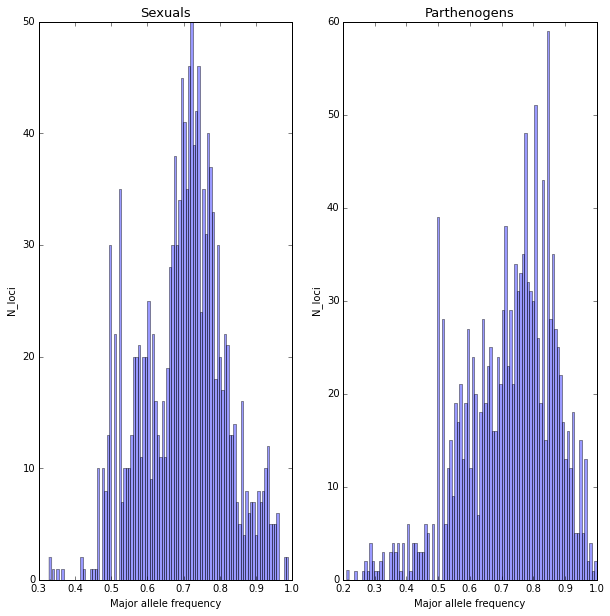

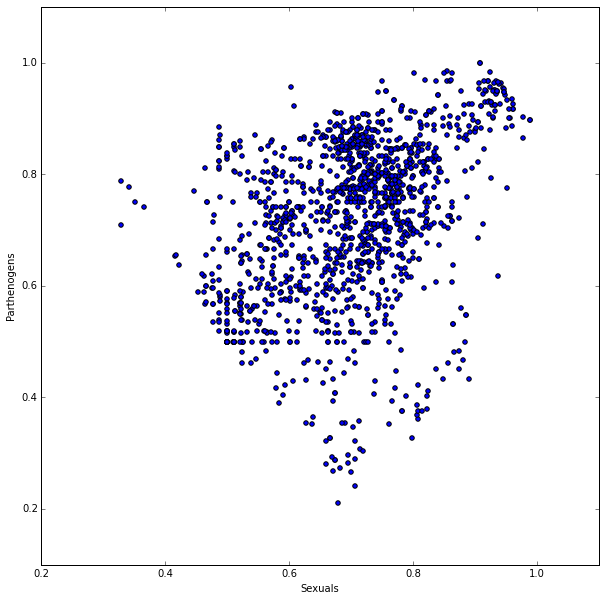

Average SNP Coverages across samples
Number of tags =  1449
Average tag coverage 61.7365362069 (+- 45.8825842965 )


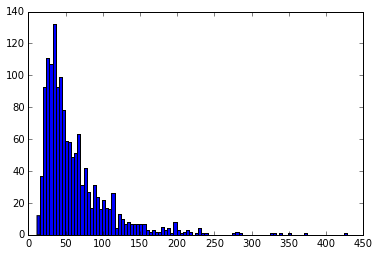

Average sample Coverages across SNPS


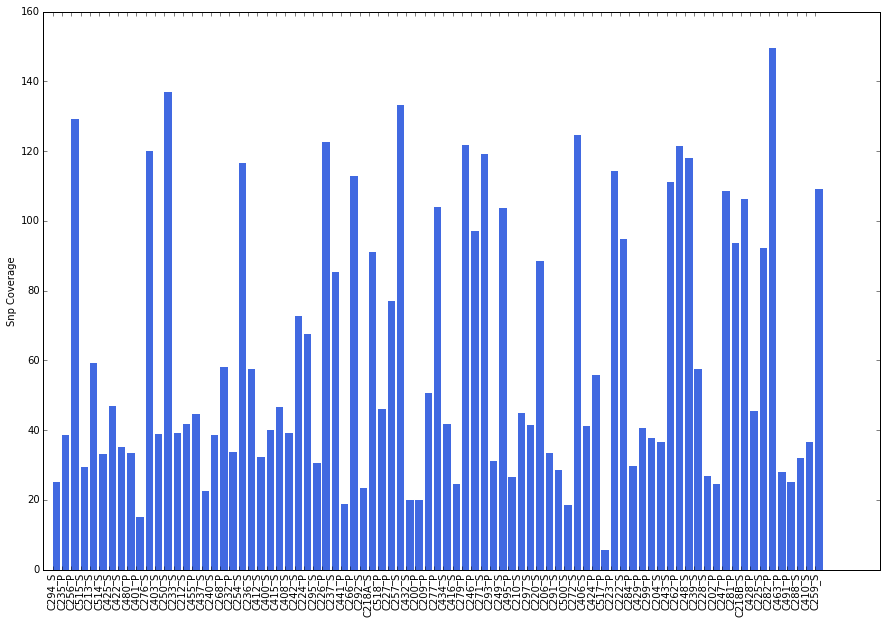

In [43]:
print "Site Frequency spectrum"
Freq_plotter(open(vcf_L2_all_sumstats, 'r'))
print "Average SNP Coverages across samples"
MISC_RAD_tools.av_tag_cov(vcf_L2_all_alt, "/home/djeffrie/Data/Caspers_data/2lanes/Stacks_outs/Populations_all/Av_snp_cov.txt")
print "Average sample Coverages across SNPS"
MISC_RAD_tools.sample_Avcov_from_vcf(vcf_L2_all_alt, "/home/djeffrie/Data/Caspers_data/2lanes/Stacks_outs/Populations_all/Av_sample_cov.txt")

In [112]:
## Run the function over the vcf

vcf_read = vcf.Reader(open(vcf_L2_all_alt, 'r'))

## Useing the parth_loc_finder function. This function looks for loci that exactly fit the recessive mendelien inheritance pattern we expect to see.
## Two important thresholds:
# parth_threshold = the proportion of parthenogens that must be homozygous for the same allele
# sexuals_threshold = the proportion of sexuals that must be homozygous for the "non-parthenogen" allele or heterozygous

for vcfrecord in vcf_read:
    parth_loc_finder(vcfrecord, parthenogens, sexuals, 0.6, 0.8) ## parth_loc_finder(record, parth_list, sexuals_list parth_threshold, sexuals_threshold)


Locus 1510_140361
Threshold number of Parthenogens = 15.6 and Sexuals = 33.6
The number of homozygous Parthenogens = 17 out of 26 called
The number of Sexuals not homozygous for same allele = 39 out of 42 called
So enough Parthenogens are over the homozygosity threshold for one allele
And enough sexuals are heterozygous or homozygous for alternative allele

Locus 1510_140386
Threshold number of Parthenogens = 15.6 and Sexuals = 32.8
The number of homozygous Parthenogens = 17 out of 26 called
The number of Sexuals not homozygous for same allele = 38 out of 41 called
So enough Parthenogens are over the homozygosity threshold for one allele
And enough sexuals are heterozygous or homozygous for alternative allele


Again the thresholds have to be too low. In general it seems that is is the parthenogensis threshold that has the biggest effect, no loci are found unless this is about 0.6

### Both lanes, best samples only

41 Sexuals ['C249_S', 'C213_S', 'C204_S', 'C218B_S', 'C220_S', 'C243_S', 'C248_S', 'C210_S', 'C212_S', 'C271_S', 'C425_S', 'C240_S', 'C292_S', 'C225_S', 'C233_S', 'C422_S', 'C254_S', 'C412_S', 'C416_S', 'C228_S', 'C500_S', 'C242_S', 'C291_S', 'C295_S', 'C403_S', 'C408_S', 'C434_S', 'C237_S', 'C239_S', 'C294_S', 'C276_S', 'C297_S', 'C415_S', 'C406_S', 'C272_S', 'C400_S', 'C259_S', 'C515_S', 'C437_S', 'C514_S', 'C410_S']
32 Parthenogens ['C200_P', 'C202_P', 'C262_P', 'C429_P', 'C224_P', 'C246_P', 'C268_P', 'C223_P', 'C441_P', 'C209_P', 'C247_P', 'C282_P', 'C401_P', 'C455_P', 'C227_P', 'C232_P', 'C279_P', 'C293_P', 'C424_P', 'C428_P', 'C463_P', 'C277_P', 'C281_P', 'C284_P', 'C266_P', 'C518_P', 'C256_P', 'C235_P', 'C491_P', 'C495_P', 'C517_P', 'C480_P']
Site Frequency spectrum


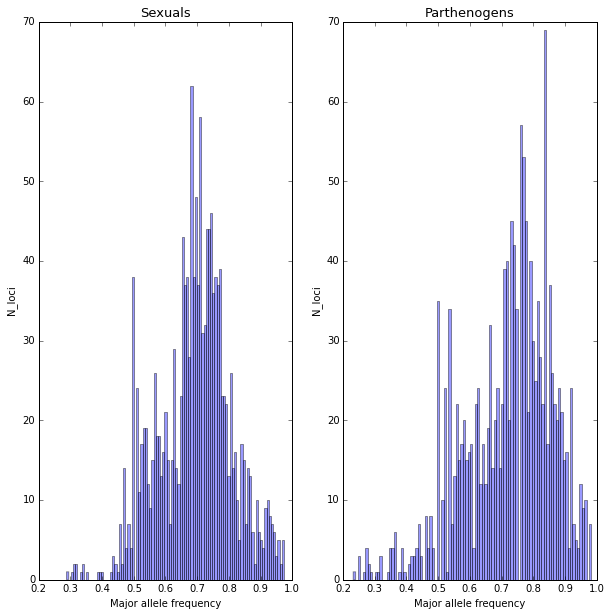

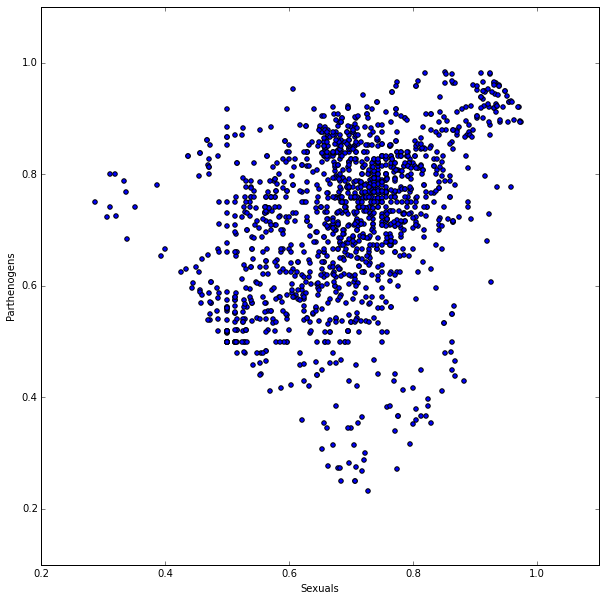

Average SNP Coverages across samples
Number of tags =  1491
Average tag coverage 59.7564381724 (+- 44.5510887181 )


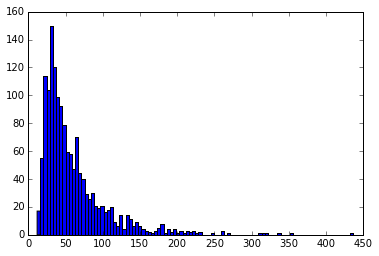

Average sample Coverages across SNPS


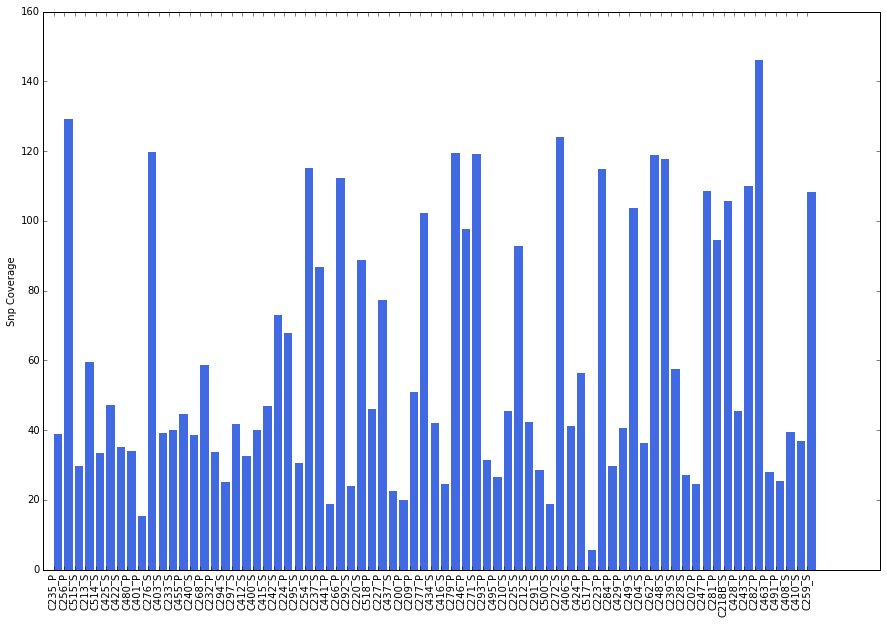

In [115]:
## get numbers of sexuals and parthenogens
sexuals, parthenogens = get_sex_info(vcf_L2_best_popmap)
print "Site Frequency spectrum"
Freq_plotter(open(vcf_L2_best_sumstats, 'r'))
print "Average SNP Coverages across samples"
MISC_RAD_tools.av_tag_cov(vcf_L2_best_alt, "/home/djeffrie/Data/Caspers_data/2lanes/Stacks_outs/Populations_best_kept//Av_snp_cov.txt")
print "Average sample Coverages across SNPS"
MISC_RAD_tools.sample_Avcov_from_vcf(vcf_L2_best_alt, "/home/djeffrie/Data/Caspers_data/2lanes/Stacks_outs/Populations_best_kept//Av_sample_cov.txt")

In [117]:
## Run the function over the vcf

vcf_read = vcf.Reader(open(vcf_L2_best_alt, 'r'))

## Useing the parth_loc_finder function. This function looks for loci that exactly fit the recessive mendelien inheritance pattern we expect to see.
## Two important thresholds:
# parth_threshold = the proportion of parthenogens that must be homozygous for the same allele
# sexuals_threshold = the proportion of sexuals that must be homozygous for the "non-parthenogen" allele or heterozygous

for vcfrecord in vcf_read:
    parth_loc_finder(vcfrecord, parthenogens, sexuals, 0.8, 0.8) ## parth_loc_finder(record, parth_list, sexuals_list parth_threshold, sexuals_threshold)

Same story! Here

### Clutch 26

So the idea here is that, there is the possibility that the initial male that was used for the crosses was diploid, and could have contained two parthenogenesis alleles. So if this was the case, this could violate the assumptions we are making about allele freqs in parthenogens, i.e. they could be heterozygous at loci linked to the parthenogenesis-causing-locus. However, within a clutch, sisters must have identical parthenogenesis alleles. So if we restrict the analyses to just parthenogens in one clutch, our expectation of mendelien inheritance should hold.

The problem here though is that the number of samples in each clutch is very low. So we are likely to get lots of false positives. However, if we do this across multiple clutches, we may be able to narrow down the set of loci to those which are shared by all clutches. We can then further validate by looking at linkage between these loci, i.e. where they map on the genome.

41 Sexuals ['C249_S', 'C213_S', 'C204_S', 'C218B_S', 'C220_S', 'C243_S', 'C248_S', 'C210_S', 'C212_S', 'C271_S', 'C425_S', 'C240_S', 'C292_S', 'C225_S', 'C233_S', 'C422_S', 'C254_S', 'C412_S', 'C416_S', 'C228_S', 'C500_S', 'C242_S', 'C291_S', 'C295_S', 'C403_S', 'C408_S', 'C434_S', 'C237_S', 'C239_S', 'C294_S', 'C276_S', 'C297_S', 'C415_S', 'C406_S', 'C272_S', 'C400_S', 'C259_S', 'C515_S', 'C437_S', 'C514_S', 'C410_S']
4 Parthenogens ['C247_P', 'C282_P', 'C401_P', 'C455_P']
Site Frequency spectrum


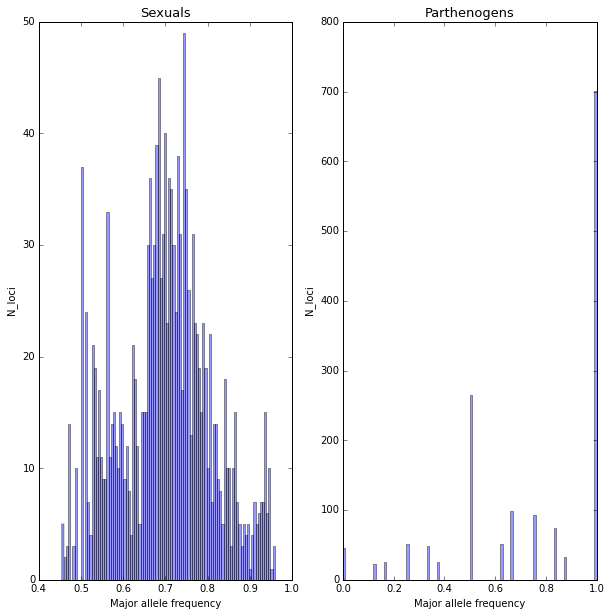

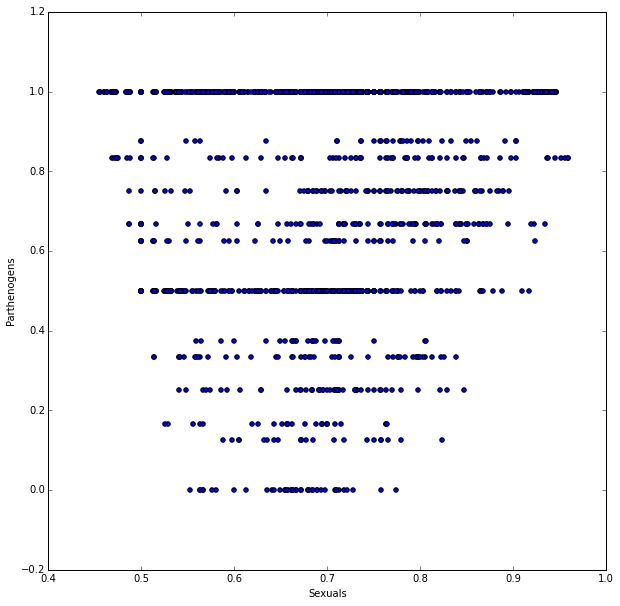

Average SNP Coverages across samples
Number of tags =  1534
Average tag coverage 57.4822251195 (+- 44.6246820889 )


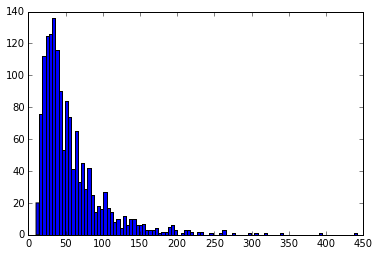

Average sample Coverages across SNPS


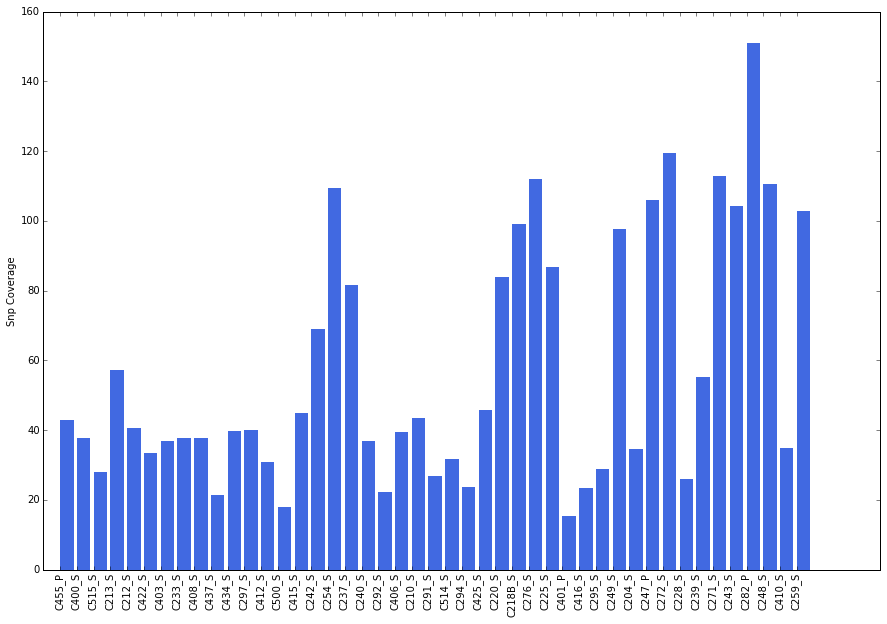

In [119]:
sexuals, parthenogens = get_sex_info(vcf_c026_popmap)
print "Site Frequency spectrum"
Freq_plotter(open(vcf_c026_sumstats, 'r'))
print "Average SNP Coverages across samples"
MISC_RAD_tools.av_tag_cov(vcf_c026_alt, "/home/djeffrie/Data/Caspers_data/2lanes/Stacks_outs/Populations_clutch_026//Av_snp_cov.txt")
print "Average sample Coverages across SNPS"
MISC_RAD_tools.sample_Avcov_from_vcf(vcf_c026_alt, "/home/djeffrie/Data/Caspers_data/2lanes/Stacks_outs/Populations_clutch_026//Av_sample_cov.txt")

In [128]:
## Run the function over the vcf

vcf_read = vcf.Reader(open(vcf_c026_alt, 'r'))

## Useing the parth_loc_finder function. This function looks for loci that exactly fit the recessive mendelien inheritance pattern we expect to see.
## Two important thresholds:
# parth_threshold = the proportion of parthenogens that must be homozygous for the same allele
# sexuals_threshold = the proportion of sexuals that must be homozygous for the "non-parthenogen" allele or heterozygous

for vcfrecord in vcf_read:
    parth_loc_finder(vcfrecord, parthenogens, sexuals, 1, 0.95) ## parth_loc_finder(record, parth_list, sexuals_list parth_threshold, sexuals_threshold)


Locus 1203_111835
Threshold number of Parthenogens = 3 and Sexuals = 34.2
The number of homozygous Parthenogens = 3 out of 3 called
The number of Sexuals not homozygous for same allele = 35 out of 36 called
So enough Parthenogens are over the homozygosity threshold for one allele
And enough sexuals are heterozygous or homozygous for alternative allele

Locus 7831_728217
Threshold number of Parthenogens = 4 and Sexuals = 38.95
The number of homozygous Parthenogens = 4 out of 4 called
The number of Sexuals not homozygous for same allele = 40 out of 41 called
So enough Parthenogens are over the homozygosity threshold for one allele
And enough sexuals are heterozygous or homozygous for alternative allele

Locus 10910_1014559
Threshold number of Parthenogens = 4 and Sexuals = 37.05
The number of homozygous Parthenogens = 4 out of 4 called
The number of Sexuals not homozygous for same allele = 38 out of 39 called
So enough Parthenogens are over the homozygosity threshold for one allele
And 

So we have a set of loci from this clutch that are candidates. Note though, that no loci fit if I use a threshold of 100% in the sexuals

### Clutch 30 

41 Sexuals ['C249_S', 'C213_S', 'C204_S', 'C218B_S', 'C220_S', 'C243_S', 'C248_S', 'C210_S', 'C212_S', 'C271_S', 'C425_S', 'C240_S', 'C292_S', 'C225_S', 'C233_S', 'C422_S', 'C254_S', 'C412_S', 'C416_S', 'C228_S', 'C500_S', 'C242_S', 'C291_S', 'C295_S', 'C403_S', 'C408_S', 'C434_S', 'C237_S', 'C239_S', 'C294_S', 'C276_S', 'C297_S', 'C415_S', 'C406_S', 'C272_S', 'C400_S', 'C259_S', 'C515_S', 'C437_S', 'C514_S', 'C410_S']
5 Parthenogens ['C227_P', 'C232_P', 'C279_P', 'C293_P', 'C424_P']
Site Frequency spectrum


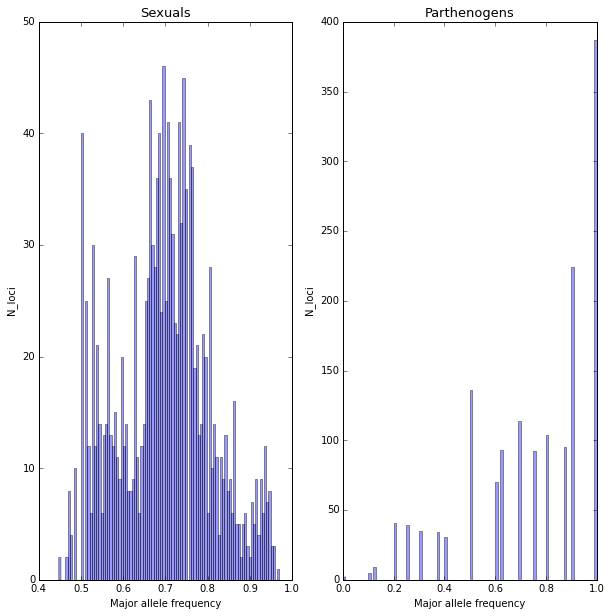

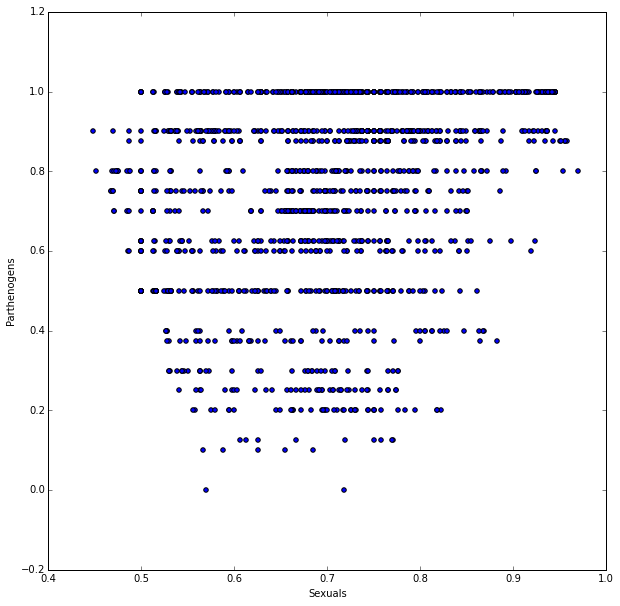

Average SNP Coverages across samples
Number of tags =  1511
Average tag coverage 56.2534313584 (+- 42.4106184724 )


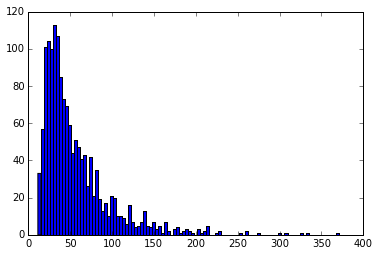

Average sample Coverages across SNPS


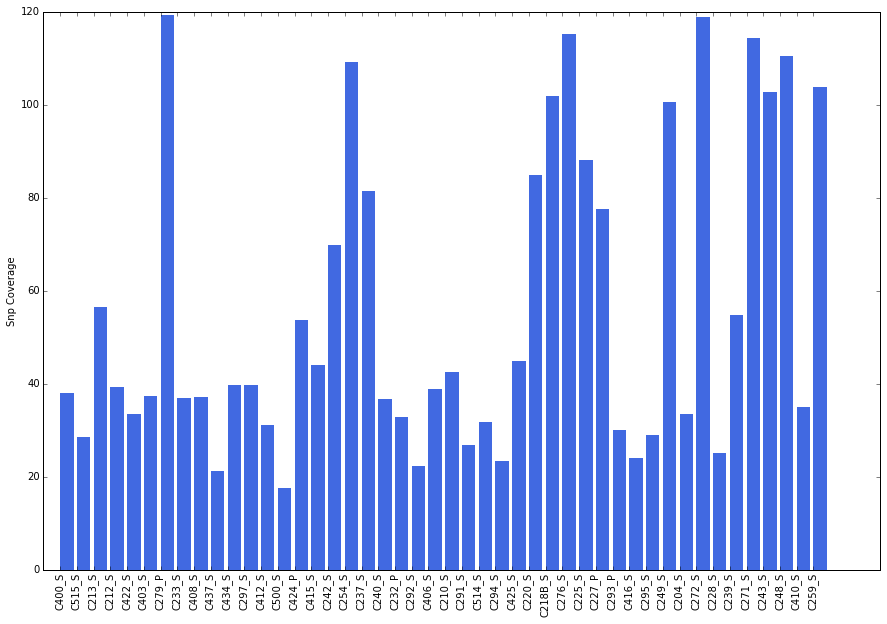

In [149]:
sexuals, parthenogens = get_sex_info(vcf_c030_popmap)
print "Site Frequency spectrum"
Freq_plotter(open(vcf_c030_sumstats, 'r'))
print "Average SNP Coverages across samples"
MISC_RAD_tools.av_tag_cov(vcf_c030_alt, "/home/djeffrie/Data/Caspers_data/2lanes/Stacks_outs/Populations_clutch_030//Av_snp_cov.txt")
print "Average sample Coverages across SNPS"
MISC_RAD_tools.sample_Avcov_from_vcf(vcf_c030_alt, "/home/djeffrie/Data/Caspers_data/2lanes/Stacks_outs/Populations_clutch_030//Av_sample_cov.txt")

In [156]:
## Run the function over the vcf

vcf_read = vcf.Reader(open(vcf_c030_alt, 'r'))

## Useing the parth_loc_finder function. This function looks for loci that exactly fit the recessive mendelien inheritance pattern we expect to see.
## Two important thresholds:
# parth_threshold = the proportion of parthenogens that must be homozygous for the same allele
# sexuals_threshold = the proportion of sexuals that must be homozygous for the "non-parthenogen" allele or heterozygous

for vcfrecord in vcf_read:
    parth_loc_finder(vcfrecord, parthenogens, sexuals, 0.8, 0.9) ## parth_loc_finder(record, parth_threshold, sexuals_threshold)


Locus 71_6550
Threshold number of Parthenogens = 4.0 and Sexuals = 36.0
The number of homozygous Parthenogens = 5 out of 5 called
The number of Sexuals not homozygous for same allele = 36 out of 40 called
So enough Parthenogens are over the homozygosity threshold for one allele
And enough sexuals are heterozygous or homozygous for alternative allele

Locus 454_42148
Threshold number of Parthenogens = 4.0 and Sexuals = 34.2
The number of homozygous Parthenogens = 5 out of 5 called
The number of Sexuals not homozygous for same allele = 35 out of 38 called
So enough Parthenogens are over the homozygosity threshold for one allele
And enough sexuals are heterozygous or homozygous for alternative allele

Locus 523_48609
Threshold number of Parthenogens = 4.0 and Sexuals = 33.3
The number of homozygous Parthenogens = 5 out of 5 called
The number of Sexuals not homozygous for same allele = 34 out of 37 called
So enough Parthenogens are over the homozygosity threshold for one allele
And enough

### Clutch 91

41 Sexuals ['C249_S', 'C213_S', 'C204_S', 'C218B_S', 'C220_S', 'C243_S', 'C248_S', 'C210_S', 'C212_S', 'C271_S', 'C425_S', 'C240_S', 'C292_S', 'C225_S', 'C233_S', 'C422_S', 'C254_S', 'C412_S', 'C416_S', 'C228_S', 'C500_S', 'C242_S', 'C291_S', 'C295_S', 'C403_S', 'C408_S', 'C434_S', 'C237_S', 'C239_S', 'C294_S', 'C276_S', 'C297_S', 'C415_S', 'C406_S', 'C272_S', 'C400_S', 'C259_S', 'C515_S', 'C437_S', 'C514_S', 'C410_S']
4 Parthenogens ['C235_P', 'C491_P', 'C495_P', 'C517_P']
Site Frequency spectrum


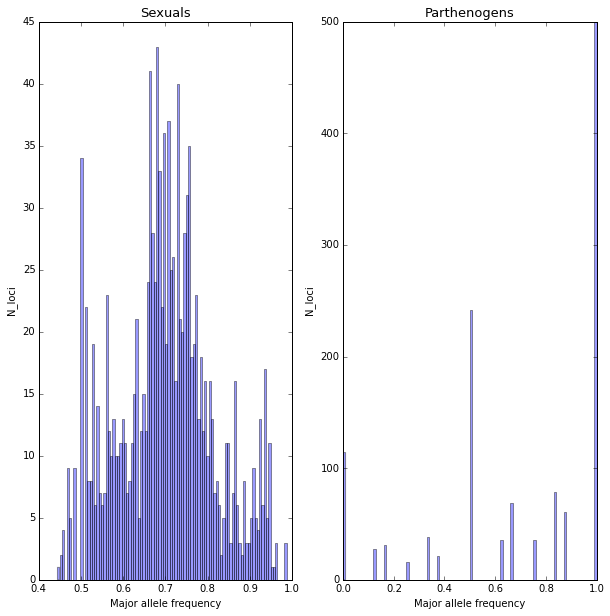

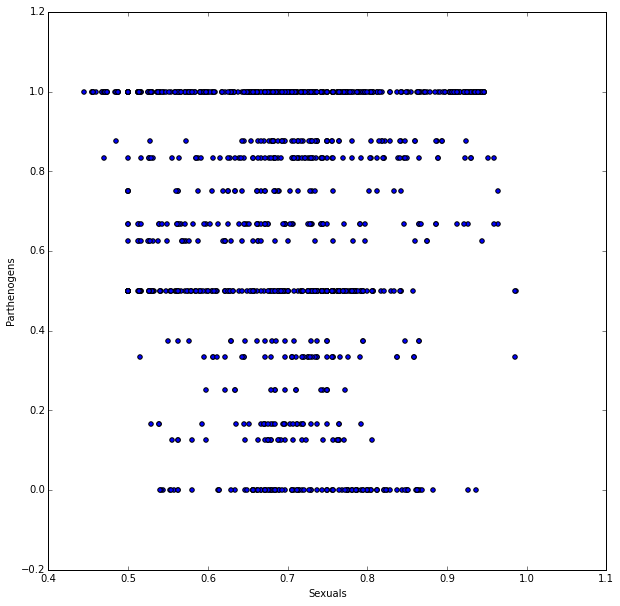

Average SNP Coverages across samples
Number of tags =  1271
Average tag coverage 61.9004108751 (+- 45.1071687228 )


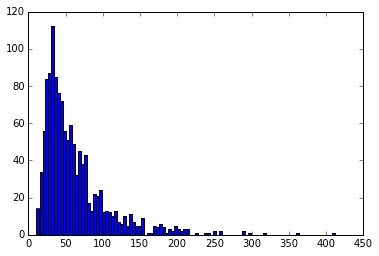

Average sample Coverages across SNPS


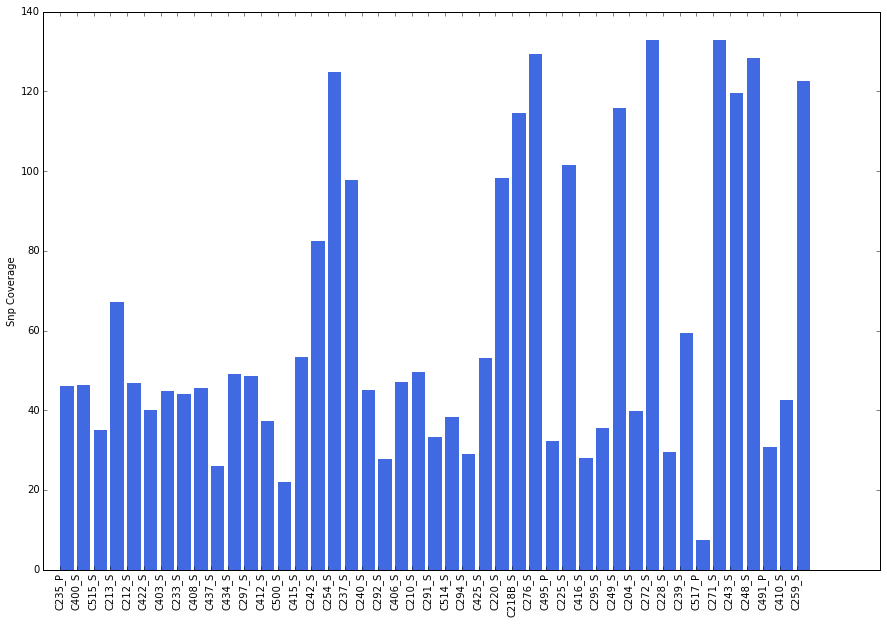

In [135]:
sexuals, parthenogens = get_sex_info(vcf_c091_popmap)
print "Site Frequency spectrum"
Freq_plotter(open(vcf_c091_sumstats, 'r'))
print "Average SNP Coverages across samples"
MISC_RAD_tools.av_tag_cov(vcf_c091_alt, "/home/djeffrie/Data/Caspers_data/2lanes/Stacks_outs/Populations_clutch_091//Av_snp_cov.txt")
print "Average sample Coverages across SNPS"
MISC_RAD_tools.sample_Avcov_from_vcf(vcf_c091_alt, "/home/djeffrie/Data/Caspers_data/2lanes/Stacks_outs/Populations_clutch_091//Av_sample_cov.txt")

In [147]:
## Run the function over the vcf

vcf_read = vcf.Reader(open(vcf_c091_alt, 'r'))

## Useing the parth_loc_finder function. This function looks for loci that exactly fit the recessive mendelien inheritance pattern we expect to see.
## Two important thresholds:
# parth_threshold = the proportion of parthenogens that must be homozygous for the same allele
# sexuals_threshold = the proportion of sexuals that must be homozygous for the "non-parthenogen" allele or heterozygous

for vcfrecord in vcf_read:
    parth_loc_finder(vcfrecord, parthenogens, sexuals, 1, 0.95) ## parth_loc_finder(record, parth_threshold, sexuals_threshold)



Locus 57_5266
Threshold number of Parthenogens = 4 and Sexuals = 38.95
The number of homozygous Parthenogens = 4 out of 4 called
The number of Sexuals not homozygous for same allele = 41 out of 41 called
So enough Parthenogens are over the homozygosity threshold for one allele
And enough sexuals are heterozygous or homozygous for alternative allele

Locus 503_46723
Threshold number of Parthenogens = 3 and Sexuals = 38.0
The number of homozygous Parthenogens = 3 out of 3 called
The number of Sexuals not homozygous for same allele = 40 out of 40 called
So enough Parthenogens are over the homozygosity threshold for one allele
And enough sexuals are heterozygous or homozygous for alternative allele

Locus 503_46732
Threshold number of Parthenogens = 3 and Sexuals = 38.0
The number of homozygous Parthenogens = 3 out of 3 called
The number of Sexuals not homozygous for same allele = 40 out of 40 called
So enough Parthenogens are over the homozygosity threshold for one allele
And enough sexu

### Overlap between the loci identified from different clutches. 

There is soomething strange going on with clutch 3, which suggests to me that there is something weird in the data. 

However, clutches 26 and 91 share 6 loci which fit (almost perfectly) our expectations (only one sexual sample doesn't fit the criteria
    - is this always the same sexual sample??
    - what is wrong with clutch 30?
    
    
